<a href="https://colab.research.google.com/github/NG1903/Face_Recognition/blob/master/FaceRecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloned my Git

In [1]:
!git clone https://github.com/NG1903/Face_Recognition.git

fatal: destination path 'Face_Recognition' already exists and is not an empty directory.


In [2]:
%cd /content/Face_Recognition/

/content/Face_Recognition


Used FaceNet pretrained weights and used Inception model with his softmax layer removed. Used the last Fully connected layer with 128 params as the encodings for each image. One Shot learning has been used which aims to learn information about object categories from one, or only a few, training samples/images.

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


The model only works for 96\*96\*3 images, thus on downsizing images leads to a lot of information loss. Can be improved by using a model trained with larger images.


In [5]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

For each user a few images are selected and passed through the pretrained model to get their encodings of length 128. These encodings are saved in a dictionary for quick access.

In [6]:
database = {}
database["User1_1"] = img_to_encoding('images/User1_1.jpg', FRmodel)
database["User1_2"] = img_to_encoding('images/User1_2.jpg', FRmodel)
database["User1_3"] = img_to_encoding('images/User1_3.jpg', FRmodel)
database["User2_1"] = img_to_encoding('images/User2_1.jpg', FRmodel)
database["User2_2"] = img_to_encoding('images/User2_2.jpg', FRmodel)
database["User2_3"] = img_to_encoding('images/User2_3.jpg', FRmodel)
database["User3_1"] = img_to_encoding('images/User3_1.jpg', FRmodel)
database["User3_2"] = img_to_encoding('images/User3_2.jpg', FRmodel)
database["User3_3"] = img_to_encoding('images/User3_3.jpg', FRmodel)
# database["User4_1"] = img_to_encoding('images/User4_1.jpg', FRmodel)
# database["User4_2"] = img_to_encoding('images/User4_2.jpg', FRmodel)

We maintain a excel sheet at backend to store the details of the above users. These excel sheet can also be automatically updated for tasks like marking attendance.

In [7]:
df = pd.read_excel('Dataset.xlsx')
def getUser(i):
  print(df.iloc[i-1]['User'] + ", " + df.iloc[i-1]['Description'] + " has been recognised.")

The below algo checks for the distance between the encoding of the target image and the images in the database. We output the one with the lowest distance and below the given threshhold.

Below it is a function for using colab api for accessing webcam for capturing image

In [8]:
def who_is_it(image_path, database, model):
    encoding = img_to_encoding(image_path, model)
    min_dist = 100
    
    for name in database:
        dist = np.linalg.norm(database[name] - encoding,ord=2)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        getUser(int(str(identity)[-3]))
        
    return min_dist, identity

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

We use the OpenCV face-recognition algo, haarcascade to detect the face and save the region of interest.

In [9]:
def Face(photo):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  img = cv2.imread(photo) + 60
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
      cv2.rectangle(img,(x-25,y-25),(x+w+25,y+h+25),(0,255,0),2)
      X = x
      Y = y
      W = w
      H = h

  roi = img[Y-25:Y+H+25, X-25:X+W+25]  
  cv2.imwrite('roi.jpg', roi)

The below code lets you run the webcam and you have to click capture for processing the image

In [10]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


Testing

Rowan Sebastian Atkinson, English actor, comedian, and writer has been recognised.


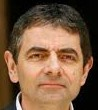

In [11]:
_, id = who_is_it('test1.jpg', database, FRmodel)
display(Image('test1.jpg'))

In [ ]:
Face('photo.jpg')
who_is_it('roi.jpg', database, FRmodel)